In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [11]:
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').\
       group_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-23,0.70
1,2016-08-24,1.45
2,2016-08-25,0.11
3,2016-08-26,0.01
4,2016-08-27,NaN


In [13]:
# Sort the dataframe by date
rain_sorted_df = rain_df.set_index("date")
rain_sorted_df.head()

,prcp
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN


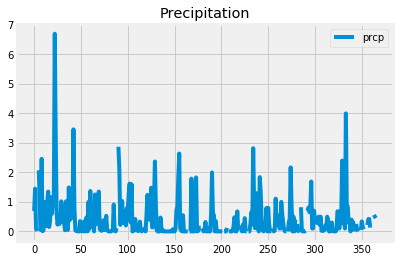

In [14]:
# Pandas Plotting with Matplotlib to plot the data
rain_df.plot()
plt.title("Precipitation")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_stats = rain_df.describe()
rain_stats

,prcp
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


# Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
        
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

USC00519281 is the most active station

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Filter by busiest station for the 12 months.
most_active = active_station[0][0]


tobs = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23', Measurement.station == most_active).all()
tobs_df = pd.DataFrame(tobs)

tobs_df.describe()

,tobs
count,352.000000
mean,73.107955
std,4.733315
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


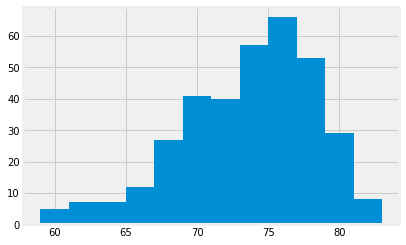

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(tobs_df["tobs"], bins=12)
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 2, 10)
trip_leave = dt.date(2018, 2, 20)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(62.0, 71.40298507462687, 80.0)]


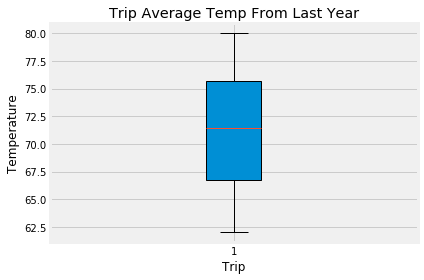

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temp From Last Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start = '2018-02-10'
end = '2018-02-20'

dateStart = dt.datetime.strptime(start, "%Y-%m-%d").date()
dateEnd = dt.datetime.strptime(end, "%Y-%m-%d").date()

# Find the date after timedelta (one year)
yearAgoStart = dateStart - dt.timedelta(days=365)
yearAgoEnd = dateEnd - dt.timedelta(days=365)

trip_precipitation = session.query(Station.station, Station.name, Station.latitude, Station.longitude, 
                          Station.elevation, func.avg(Measurement.prcp))\
                            .filter(Station.station == Measurement.station)\
                            .filter(Measurement.date >= yearAgoStart, Measurement.date <= yearAgoEnd)\
                            .group_by(Station.station)\
                            .order_by(func.avg(Measurement.prcp).desc()).all()

trip_precipitation

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.8357142857142856),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.6224999999999999),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.5245454545454545),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.5163636363636362),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.31888888888888883),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.2736363636363636),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

# Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals('02-10')

[(56.0, 68.41666666666667, 76.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
dates = np.arange(yearAgoStart, yearAgoEnd)

# Stip off the year and save a list of %m-%d strings
short_dates = []
for date in dates:
    string_date = str(date)
    test = string_date.split('-', 1)
    short_dates.append(test[1])

print(short_dates)

# Loop through the list of %m-%d strings and calculate the normals for each date
norms = []
for day in short_dates:
    norms.append(daily_normals(day))

print(norms)


['02-10', '02-11', '02-12', '02-13', '02-14', '02-15', '02-16', '02-17', '02-18', '02-19']
[[(56.0, 68.41666666666667, 76.0)], [(61.0, 69.25, 79.0)], [(60.0, 69.15789473684211, 78.0)], [(58.0, 70.36206896551724, 80.0)], [(62.0, 70.89473684210526, 79.0)], [(56.0, 70.28813559322033, 79.0)], [(59.0, 70.48214285714286, 76.0)], [(62.0, 70.47272727272727, 77.0)], [(63.0, 70.79629629629629, 77.0)], [(60.0, 69.33962264150944, 77.0)]]


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
startDT = dt.datetime.strptime(start, "%Y-%m-%d")
endDT = dt.datetime.strptime(end, "%Y-%m-%d")
date_generated = [startDT + dt.timedelta(days=x) for x in range(0, (endDT-startDT).days)]
strDates = []
mins = []
maxs = []
avgs = []
for gen in date_generated:
    strDates.append(gen.strftime("%Y-%m-%d"))
for norm in norms:
    mins.append(float(norm[0][0]))
    avgs.append(float(norm[0][1]))
    maxs.append(float(norm[0][2]))
normals = pd.DataFrame({'Date':strDates, 'Min Temp': mins, 'Avg Temp': avgs, 'Max Temp': maxs})
normals

,Date,Min Temp,Avg Temp,Max Temp
0,2018-02-10,56.0,68.416667,76.0
1,2018-02-11,61.0,69.250000,79.0
2,2018-02-12,60.0,69.157895,78.0
3,2018-02-13,58.0,70.362069,80.0
4,2018-02-14,62.0,70.894737,79.0
5,2018-02-15,56.0,70.288136,79.0
6,2018-02-16,59.0,70.482143,76.0
7,2018-02-17,62.0,70.472727,77.0
8,2018-02-18,63.0,70.796296,77.0
9,2018-02-19,60.0,69.339623,77.0


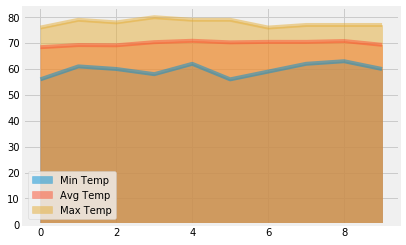

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
# normals_df = normals_df[['Max Temp', 'Average Temp', 'Min Temp']]

# normals_df.plot(kind = 'area', stacked = False, alpha = .75, rot = 45, color = ['teal', 'navajowhite', 'aqua'], figsize = (10,5), linestyle = 'solid')
# plt.xlabel('Date')
# plt.ylabel('Temperature (F)')
# plt.legend(frameon = True)
# plt.show()

normals.plot.area(stacked=False)